In [28]:
%matplotlib inline

import pandas as pd
import datetime
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import statistics
from scipy import signal
import random
import uuid
import json

In [146]:
#Model parameters
num_machines = 10
num_prod_lines = 5

fault_prob = [0.001, 0.003, 0.005]

scenarios = {
    "normal":
    {
        "avg_yield": 1500,
        "std_yield": 5,
        "avg_perc_defects": 0.01,
        "std_perc_defects": 0.001,
        "avg_energy_cons": 10000,
        "std_energy_cons": 200
    },
    "abnormal": 
    {
        "avg_yield": 1500,
        "std_yield": 10,
        "avg_perc_defects": 0.03,
        "std_perc_defects": 0.003,
        "avg_energy_cons": 20000,
        "std_energy_cons": 500,
    },
    "highly_abnormal": 
    {
        "avg_yield": 1500,
        "std_yield": 20,
        "avg_perc_defects": 0.05,
        "std_perc_defects": 0.005,
        "avg_energy_cons": 30000,
        "std_energy_cons": 500,
    },
    "brakdown": 
    {
        "avg_yield": 0,
        "std_yield": 0,
        "avg_perc_defects": 0,
        "std_perc_defects": 0,
        "avg_energy_cons": 0,
        "std_energy_cons": 0,
    }
}

In [141]:
def gaussian_distr(mean, std, size):
    return np.random.normal(loc=mean, scale=std, size=size)

def possoin_distr(prob, size):
    return np.random.poisson(lam=prob, size=size)

a = gaussian_distr(scenarios["normal"]["avg_yield"], scenarios["normal"]["std_yield"], 10000)
b = gaussian_distr(scenarios["normal"]["avg_perc_defects"], scenarios["normal"]["std_perc_defects"], 10000)
#print(a)
#c = possoin_distr(scenarios["normal"]["fault_prob"], 2000)
#print(c)

In [154]:
import random
x =  random.sample(fault_prob, 1)
print(x)

[0.003]


In [152]:
def plot_hist(data, step, title):
    fig, ax = plt.subplots()
    #plt.xlabel("a")
    #plt.ylabel(r"b")
    ax.grid()
    plt.hist(data, bins=np.arange(data.min(), data.max(), step))
    plt.title(title)
    plt.show();

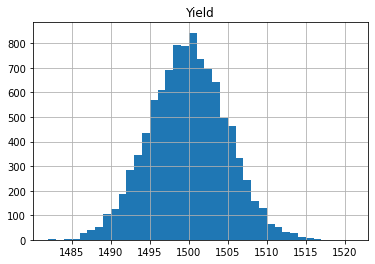

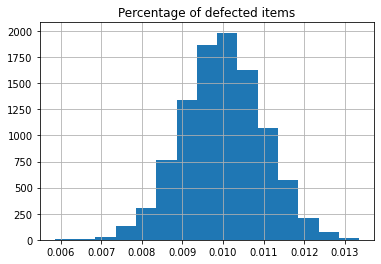

In [133]:
plot_hist(a, 1, "Yield")
plot_hist(b, 0.0005, "Percentage of defected items")

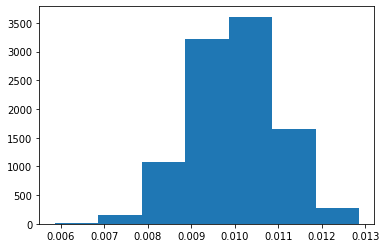

In [134]:
#plt.hist(a, bins=np.arange(a.min(), a.max()+1, 1))
plt.hist(b, bins=np.arange(b.min(), b.max(), 0.001))
plt.show()

In [138]:
def generateTimeSeries(months):
    
    date_rng = pd.date_range(start=datetime.date.today() - datetime.timedelta(months*365/12), 
                             end=datetime.date.today(), freq='H')
    df = pd.DataFrame(date_rng, columns=['Timestamp'])

    df1 = pd.DataFrame(range(1, num_machines+1), columns=['MachineID'])
    df2 = pd.DataFrame(range(1, num_prod_lines+1), columns=['ProdLineID'])

    df_tot = df2.merge(df1, how='cross')
    
    
    df_tot = df.merge(df_tot, how='cross')
    
    df_tot['EnergyCons'] = gaussian_distr(scenarios["normal"]["avg_energy_cons"], 
                                          scenarios["normal"]["std_energy_cons"], len(df_tot))
    
    df_tot['Yield'] = gaussian_distr(scenarios["normal"]["avg_yield"], 
                                          scenarios["normal"]["std_yield"], len(df_tot))
    
    df_tot['DefectedItems'] = df_tot['Yield']*gaussian_distr(scenarios["normal"]["avg_perc_defects"], 
                                          scenarios["normal"]["std_perc_defects"], len(df_tot))
    
    return df_tot

In [139]:
df = generateTimeSeries(1)

In [140]:
print(df)

       Timestamp  ProdLineID  MachineID    EnergyCons        Yield   Defected
0     2022-01-26           1          1  10088.215864  1500.385640  15.214399
1     2022-01-26           1          2   9611.199350  1496.831836  17.180533
2     2022-01-26           1          3   9886.938457  1502.002845  17.684410
3     2022-01-26           1          4   9854.265025  1495.366549  16.292385
4     2022-01-26           1          5  10094.847649  1499.628282  15.933524
...          ...         ...        ...           ...          ...        ...
36045 2022-02-25           5          6   9996.153342  1508.089774  17.459516
36046 2022-02-25           5          7   9877.083259  1496.591034  16.497211
36047 2022-02-25           5          8  10450.695274  1503.269930  13.454592
36048 2022-02-25           5          9   9745.823508  1497.707924  13.435931
36049 2022-02-25           5         10   9851.975350  1502.863540  13.335925

[36050 rows x 6 columns]
